#Assignment1

In [2]:
import IPython
from google.colab import output
display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button");
     btn.click()
     }
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect");
     btn.click()
     }
  }
setInterval(ClickConnect,60000)
'''))
print("Done.")

<IPython.core.display.Javascript object>

Done.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/My\ Drive/ML/Programming_Assignment_1/

/content/gdrive/My Drive/ML/Programming_Assignment_1


In [5]:
%ls

21100088_Assignment1_Q1+Q2.ipynb       kNN.pdf         test.csv
GoogleNews-vectors-negative300.bin.gz  stop_words.txt  train.csv


In [6]:
import pandas as pd
import numpy as np
import string
import re 
from scipy.spatial import distance
from array import *
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [7]:
with open('stop_words.txt') as s:
   content = s.readlines()
   

In [8]:
stop_words = []
A = []

In [9]:
for x in content:
  word = x.strip()
  stop_words.append(word)

In [10]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [11]:
def preprocess(x): # This is pre processing
    final_list = []
    list_final = []
    
    x = x.lower()
    #remove URL
    x = re.sub("http[:/.a-zA-z0-9]+|https[:/.a-zA-z0-9]+", '', x) #Removing links by targetting the link format
    x = re.sub("\.\.+",' ',x)   #Removing series of dots
    #split thing
    wordlist = re.split('[!;\-#?/%$&\s]', x)  #Splitting the words who have a symbol between them
    #go word by word to remove punctuation etc
    for word in wordlist:
        word = re.sub('[@!0-9]*', '', word) #Remove Numbers
        #word = word.replace('-','')
        item = word.strip(string.punctuation) #Remove punctuations
        if item not in stop_words and item is not '': 
          list_final.append(item)
    return list_final

In [12]:
train_data['Processed Tweet'] = train_data['Tweet'].map(preprocess)
test_data['Processed Tweet'] = test_data['Tweet'].map(preprocess)
train_sen = list(train_data["Sentiment"])
test_sen = list(test_data['Sentiment'])

In [13]:
vocab = []
def make_dictionary(x):   #Making My list of words
  #print(x);
  for word in x:
    if word not in vocab: 
      vocab.append(word)

In [14]:
for item in train_data['Processed Tweet']: #Making my vocabalary using the above function
    make_dictionary(item)

# Task 3 Word2Vec

In [17]:
 #!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-10-16 22:10:24--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.24.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.24.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  22.9MB/s    in 72s     

2020-10-16 22:11:36 (21.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



In [38]:

from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt       #Error fixed here


In [22]:
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [23]:
def extractfeatures(vocab_t):
  return np.mean(word2vec[vocab_t], axis=0)

In [24]:
freq_train = []
freq_test = []

for wordlist in train_data['Processed Tweet']:
  vocab1 = []
  for i in wordlist :
    if i in word2vec.vocab:
      vocab1.append(i)
  
  if len(vocab1) > 0:
    emb = extractfeatures(vocab1)
    emb = emb.tolist()
    freq_train.append(emb)

print(len(freq_train))


11680


In [25]:
for wordlist in test_data['Processed Tweet']:
  vocab1 = []
  for i in wordlist :
    if i in word2vec.vocab:
      vocab1.append(i)
  
  if len(vocab1) > 0:
    emb = extractfeatures(vocab1)
    emb = emb.tolist()
    freq_test.append(emb)

print(len(freq_test))

2921


In [26]:
  y = distance.cdist(freq_test,freq_train, 'euclidean')
  ydist = y.tolist()

In [27]:
test_data['Predicted Sentiment'] = None

In [28]:
def k_n_n(k,dist):

  while k>0:
    # print(a)
    label_k = []
    dist = np.array(dist)   #i pass a distance list to this function, argsort basically returns me a list of indexes 
    kn = dist.argsort()[:k] # distances are sorted and then their indexes are stored so i can access k_nearest
    # kn = kn.tolist()
    # print(kn)
    for i in kn:
      # print(a)
      sen = train_sen[i]  #Accessing k nearest
      label_k.append(sen)

    b = Counter(label_k)
    
    # pred = b.most_common()
#Here i am comparing the most common results and returning the 1 most common label.
    if len(b) == 1:
      return b.most_common(1)[0][0]

    elif len(b) == 2:
      if b.most_common(2)[0][1] == b.most_common(2)[1][1]:
        k -= 1
      elif b.most_common(2)[0][1] > b.most_common(2)[1][1]:
        return b.most_common(2)[0][0]
      elif b.most_common(2)[0][1] < b.most_common(2)[1][1]:
        return b.most_common(2)[1][0]

    elif len(b) == 3:
      if b.most_common(3)[0][1] == b.most_common(3)[1][1] and b.most_common(3)[0][1] == b.most_common(3)[2][1]:
        k -= 1
      elif b.most_common(3)[0][1] > b.most_common(3)[1][1] and b.most_common(3)[0][1] > b.most_common(3)[2][1] or b.most_common(3)[0][1] > b.most_common(3)[2][1] and b.most_common(3)[0][1] == b.most_common(3)[1][1] :
        return b.most_common(3)[0][0]
      elif b.most_common(3)[1][1] > b.most_common(3)[0][1] and b.most_common(3)[1][1] > b.most_common(3)[2][1] or b.most_common(3)[1][1] > b.most_common(3)[2][1] and b.most_common(3)[1][1] == b.most_common(3)[0][1] :
        return b.most_common(3)[1][0]
      elif b.most_common(3)[2][1] > b.most_common(3)[0][1] and b.most_common(3)[2][1] > b.most_common(3)[1][1] or b.most_common(3)[2][1] > b.most_common(3)[1][1] and b.most_common(3)[2][1] == b.most_common(3)[0][1] :
        return b.most_common(3)[2][0]

In [29]:
def confusion_matrix():
  a,b,c,d,e,f,g,h,i = 0,0,0,0,0,0,0,0,0
#for confusion matrix for pred_positive row 
  for k in range(len(test_data['Sentiment'])):
    if test_data['Predicted Sentiment'][k] == 'positive' and test_data['Sentiment'][k] == 'positive':
      a += 1
    elif test_data['Predicted Sentiment'][k] == 'positive' and test_data['Sentiment'][k] == 'neutral':
      b += 1
    elif test_data['Predicted Sentiment'][k] == 'positive' and test_data['Sentiment'][k] == 'negative':
      c += 1 

# for confusion matrix for pred_neutral row
    if test_data['Predicted Sentiment'][k] == 'neutral' and test_data['Sentiment'][k] == 'positive':
      d += 1
    elif test_data['Predicted Sentiment'][k] == 'neutral' and test_data['Sentiment'][k] == 'neutral':
      e += 1
    elif test_data['Predicted Sentiment'][k] == 'neutral' and test_data['Sentiment'][k] == 'negative':
      f += 1 

# Confusion matrix for pred_negative row 

    if test_data['Predicted Sentiment'][k] == 'negative' and test_data['Sentiment'][k] == 'positive':
      g += 1
    elif test_data['Predicted Sentiment'][k] == 'negative' and test_data['Sentiment'][k] == 'neutral':
      h += 1
    elif test_data['Predicted Sentiment'][k] == 'negative' and test_data['Sentiment'][k] == 'negative':
      i += 1
  
  confuse_matrix = [[a, b, c], [d, e, f], [g, h, i]]
  #Basically i get a 3D matrix as a result in row wise fassion,

  # print(confuse_matrix)
  return confuse_matrix

  

In [30]:
def accuracy(a,b,c,d,e,f,g,h,i):  ## passing a 3D matrix and calculting performance
  acc = ((a+e+i)/(a+b+c+d+e+f+g+h+i))*100
  return acc

In [31]:
def precision(a,b,c,d,e,f,g,h,i): ## 
  prec_pos = ((a)/(a+b+c))
  prec_neut = ((e)/(d+e+f))
  prec_neg = ((i)/(g+h+i))

  prec = (prec_pos + prec_neut + prec_neg)/3 #Calculating Macro precision

  return prec

In [32]:
def recall(a,b,c,d,e,f,g,h,i): 
  rec_pos = ((a)/(a+d+g))
  rec_neut = ((e)/(b+e+h))
  rec_neg = ((i)/(c+f+i))

  rec = (rec_pos + rec_neut + rec_neg)/3 #macro recall

  return rec

In [33]:
def F1_score(p,r):  ## precision and recall
  f1 = ((2*p*r)/(p+r))

  return f1

In [35]:
k = [1,3,5,7,10]  # My main function you can just change values of K here

ac = []
pr = []
rc = []
fs = [] 
for ind in k:
  ind = int(ind)
  C = []
  for i in range(len(test_data['Tweet'])):
    dist = ydist[i]
    pred = k_n_n(ind,dist)
    test_data['Predicted Sentiment'][i] = pred

  C = confusion_matrix()
  a = C[0][0] 
  b = C[0][1] 
  c = C[0][2]
  d = C[1][0] 
  e = C[1][1] 
  f = C[1][2]
  g = C[2][0] 
  h = C[2][1] 
  i = C[2][2]
  accu = accuracy(a,b,c,d,e,f,g,h,i)
  ac.append(accu)
  pre  = precision(a,b,c,d,e,f,g,h,i)*100
  pr.append(pre)
  rec = recall(a,b,c,d,e,f,g,h,i)*100
  rc.append(rec)

  f1 = F1_score(pre,rec)
  fs.append(f1)

  print("Performance for k = ",ind)
  print("accuracy", accu)
  print("Precision", pre)
  print("Recall",rec)

  print("F1 Score",f1)
  print("-----------------------------------------------")


Performance for k =  1
accuracy 70.07874015748031
Precision 61.048939855692716
Recall 59.3786843492892
F1 Score 60.20222940510284
-----------------------------------------------
Performance for k =  3
accuracy 73.29681615884971
Precision 66.21242530416936
Recall 60.05565678773805
F1 Score 62.98394056950341
-----------------------------------------------
Performance for k =  5
accuracy 74.11845258473126
Precision 68.8886492186751
Recall 58.7721962579957
F1 Score 63.42958479885794
-----------------------------------------------
Performance for k =  7
accuracy 74.25539198904485
Precision 70.94802048735353
Recall 58.36701732773385
F1 Score 64.04551877524393
-----------------------------------------------
Performance for k =  10
accuracy 74.35809654228004
Precision 73.6149690612477
Recall 57.50080169276638
F1 Score 64.56766738688216
-----------------------------------------------


Text(0.5, 1.0, 'F1 Performance Graph')

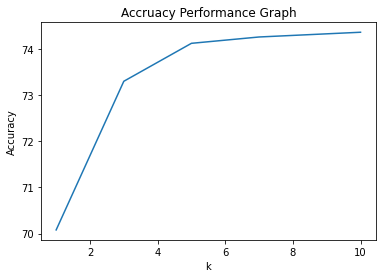

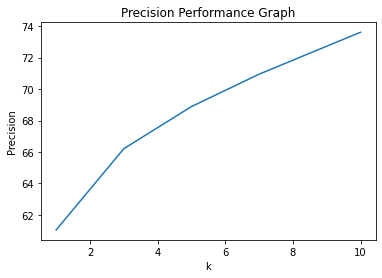

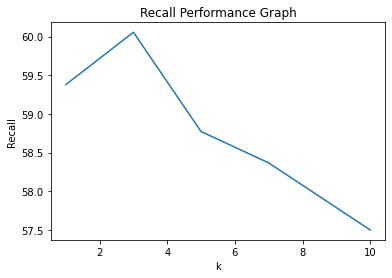

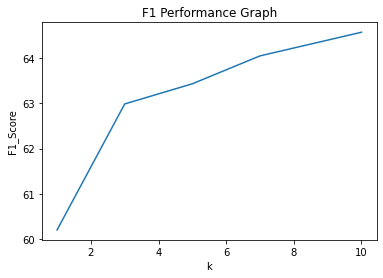

In [39]:
plt.plot(k,ac)

plt.xlabel('k')  
plt.ylabel('Accuracy') 
plt.title('Accruacy Performance Graph')

plt.figure()
plt.plot(k,pr)
plt.xlabel('k')  
plt.ylabel('Precision') 
plt.title('Precision Performance Graph')

plt.figure()
plt.plot(k,rc)
plt.xlabel('k')  
plt.ylabel('Recall') 
plt.title('Recall Performance Graph')

plt.figure()
plt.plot(k,fs)
plt.xlabel('k')  
plt.ylabel('F1_Score') 
plt.title('F1 Performance Graph')


In [42]:
euc_dist = []
pred = []
name = ['negative' , 'neutral','positive'] # labels assigned 
p2 = []
r2 = []
f2 = []
ac2 = []

k_nearest = [1,3,5,7,10]


for ind in k_nearest:
  nearest = KNeighborsClassifier(ind, algorithm = 'brute') # it uses brute algo and returns me nearest neighbours
  nearest.fit(freq_train,train_sen)  #Fits the model of training and its freq

  prediction = nearest.predict(freq_test)  #predicts the testing tweets sentiment

  print('Confusion Matrix')
  print(confusion_matrix())       # Error fixed here
  print('Classification Report')
  print(classification_report(test_sen,prediction, labels = name))
  ac = accuracy_score(test_sen,prediction)

  class_rep = classification_report(test_sen,prediction, labels = name, output_dict= True) #using dict type so i can access the table

  print("Accuracy for k = ",ind," ",ac)

  print('-----------------------------')
  # print("Classification Report")
  class_rep = np.asarray(class_rep)
  class_rep = class_rep.tolist()
  # print(class_rep)
                                          #Accessing the individual values for plotting
  p = class_rep['macro avg']['precision']
  p2.append(p)
  
  r = class_rep['macro avg']['recall']
  r2.append(r)

  f = class_rep['macro avg']['f1-score']
  f2.append(f)

  ac2.append(ac)


Confusion Matrix
[[253, 63, 16], [25, 132, 31], [194, 420, 1787]]
Classification Report
              precision    recall  f1-score   support

    negative       0.79      0.84      0.81      1834
     neutral       0.50      0.39      0.44       615
    positive       0.53      0.54      0.53       472

    accuracy                           0.70      2921
   macro avg       0.61      0.59      0.59      2921
weighted avg       0.68      0.70      0.69      2921

Accuracy for k =  1   0.6980486134885313
-----------------------------
Confusion Matrix
[[253, 63, 16], [25, 132, 31], [194, 420, 1787]]
Classification Report
              precision    recall  f1-score   support

    negative       0.76      0.93      0.84      1834
     neutral       0.60      0.29      0.39       615
    positive       0.69      0.53      0.60       472

    accuracy                           0.73      2921
   macro avg       0.68      0.59      0.61      2921
weighted avg       0.71      0.73      0.71   

[0.6980486134885313, 0.7329681615884971, 0.7408421773365286, 0.7384457377610407, 0.7353646011639849]
[0.6056030383242522, 0.6822120998279163, 0.7112308950430664, 0.7194954724174352, 0.7453048413430098]
[0.5891860511770007, 0.5859771901001637, 0.5771196634022419, 0.5702157199704448, 0.553735824426429]
[0.5945278229650618, 0.6105753611955275, 0.6056512994097695, 0.5968236589947746, 0.5814986208903896]


Text(0.5, 1.0, 'F1 Performance Graph')

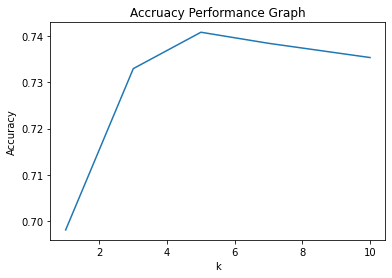

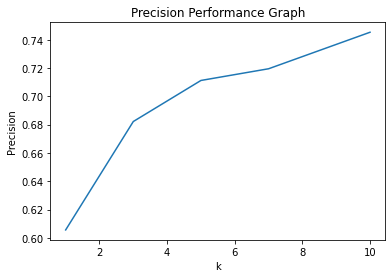

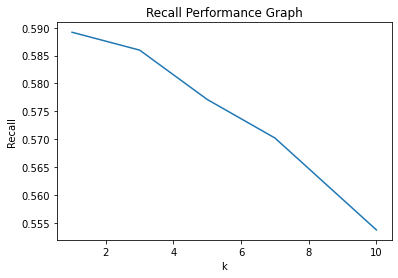

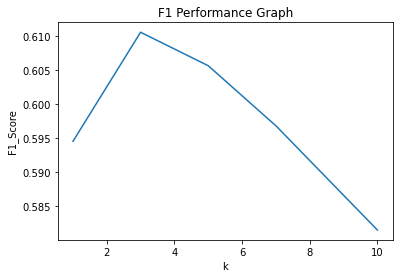

In [43]:
print(ac2)
plt.figure()
plt.plot(k,ac2)
plt.xlabel('k')  
plt.ylabel('Accuracy') 
plt.title('Accruacy Performance Graph')

print(p2)
plt.figure()
plt.plot(k,p2)
plt.xlabel('k')  
plt.ylabel('Precision') 
plt.title('Precision Performance Graph')

print(r2)
plt.figure()
plt.plot(k,r2)
plt.xlabel('k')  
plt.ylabel('Recall') 
plt.title('Recall Performance Graph')

print(f2)
plt.figure()
plt.plot(k,f2)
plt.xlabel('k')  
plt.ylabel('F1_Score') 
plt.title('F1 Performance Graph')